In [5]:
# Show the correlation between real and predicted tuning curves
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr
import pickle as pkl
from sklearn import linear_model # Loss: least squares, regularization: L2 
from sklearn.multioutput import MultiOutputRegressor

from tools.data_formatting import (
    get_smoothed_moving_all_data,
    get_common_indexes_n_recordings,
    smooth_tuning_curves_circularly,
    from_local_to_global_index,
)
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import (
    order_experiments,
    get_colors_for_each_experiment,
    animals,
    root_dir,
    experiments_to_exclude,
)

# Load the data

In [6]:
### Load all sessions ###

animal = "m135"
fov = "fov1"
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for experiment, run in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(
        animal, fov, experiment, run
    )
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Use the first session as the reference and then test the prediction of the common neurons with every other session

In [ ]:
### Align the tuning curves to a reference session ###

# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 5)
    for tuning_curves in all_tuning_curves
]
# Take the first session as the reference
ref = 0
exp0, run0 = sessions[ref]
ref_tc = smoothed_tuning_curves[ref]
ref_cells = all_cells[ref]

# Keep one neuron out and align the sessions
# Make a decoder for each neuron kept out

predicted_tuning_curves_one_out = []
reference_tuning_curves_one_out = []
pca = PCA(n_components=20)
for i in range(len(sessions) - 1):

    # Get the session to align to
    tuning_curves = smoothed_tuning_curves[i + 1]

    # Get common neurons between reference and target session
    cells_masks, ordered_cells, common_neurons = get_common_indexes_n_recordings(
        [ref_cells, all_cells[i + 1]]
    )
    # For each neuron, exclude it and then align
    tuning_curve_kept_out = []
    ref_tc_kept_out = []
    for n in range(len(common_neurons)):

        # Get indexes to remove from ref and target session
        idx_to_remove_ref = np.arange(ref_tc.shape[1])[cells_masks[0]][
            ordered_cells[0]
        ][n]
        idx_to_remove = np.arange(tuning_curves.shape[1])[cells_masks[1]][
            ordered_cells[1]
        ][n]

        # Remove the neuron from the reference and target tuning curves and get their PCA
        ref_kept_out_tc = ref_tc[:, idx_to_remove_ref] # Use for training the decoder
        sel_tc_ref = np.delete(ref_tc, idx_to_remove_ref, axis=1)
        pca_sel_tc_ref = pca.fit_transform(sel_tc_ref)
        ref_components = pca.components_.T
        
        sel_tc = np.delete(tuning_curves, idx_to_remove, axis=1)
        pca_sel_tc = pca.fit_transform(sel_tc)
        components = pca.components_.T
        
        # Align the tuning curves
        A, B, _, _, _ = canoncorr(pca_sel_tc_ref, pca_sel_tc, fullReturn=True)
        # Project the target tuning curves on the reference space
        projected_components = components @ B @ np.linalg.inv(A)

        # Make a decoder from reference PC space for ref_tc
        model = MultiOutputRegressor(linear_model.Ridge())
        model.fit(ref_components, np.tile(ref_kept_out_tc, (ref_components.shape[0], 1)))
        pred_tc = model.predict(projected_components)

        tuning_curve_kept_out.append(pred_tc[0,:])
        ref_tc_kept_out.append(ref_kept_out_tc)
        
    tuning_curves_kept_out = np.array(tuning_curve_kept_out)
    ref_tc_kept_out = np.array(ref_tc_kept_out)
    predicted_tuning_curves_one_out.append(tuning_curves_kept_out.T)
    reference_tuning_curves_one_out.append(ref_tc_kept_out.T)

Text(0.5, 1.0, 'Difference between predicted tuning curves when they are used or not in the alignment\nAs reference session: m135 fov1 fam1fam2fam1-fam1')

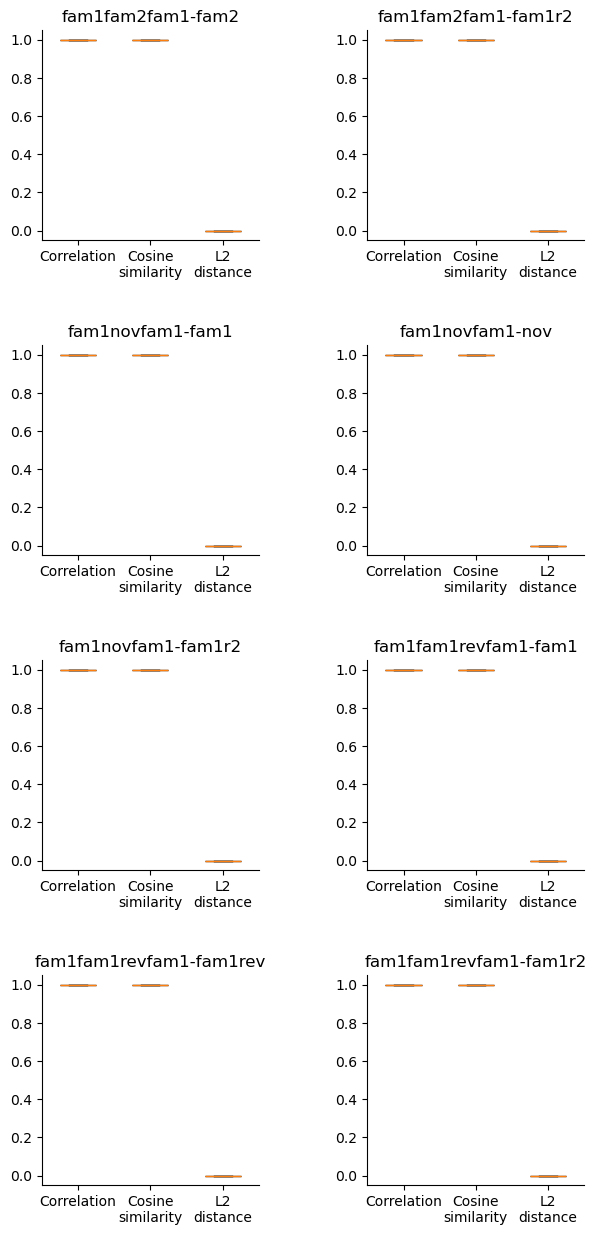

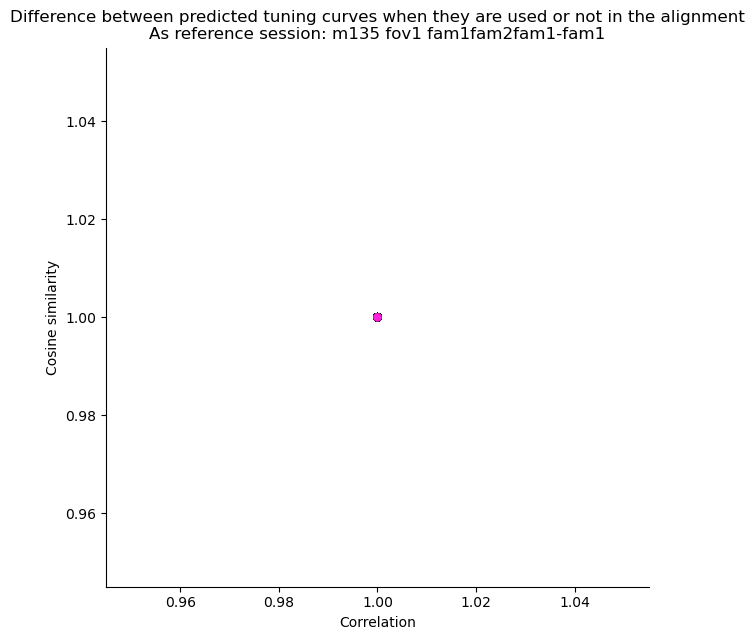

In [15]:
# Plot the difference between ref session and predicted tuning curve (while keeping the neuron out)

# Save the data for plotting later
all_correlations, all_cosine_similarities, all_r2 = [], [], []
assigned_colors = []
results = {}
results["ref_session"] = sessions[ref]


fig = plt.figure(figsize=(7, 15))
grid = plt.GridSpec(nrows=4, ncols=2, figure=fig, wspace=0.5, hspace=0.5)
colors = get_colors_for_each_experiment(sessions[1:])
for i, (exp, run) in enumerate(sessions[1:]):
    # Where to save the metrics for this session
    correlations_aligned, correlations_not_aligned = [], []
    cosine_similarities_aligned, cosine_similarities_not_aligned = [], []
    r2_aligned, r2_not_aligned = [], []
    for n in range(reference_tuning_curves_one_out[i].shape[1]):
        # Only if none of them is completely flat
        if (
            not np.all(
                reference_tuning_curves_one_out[i][:, n]
                == reference_tuning_curves_one_out[i][0, n]
            )
        ) and (
            not np.all(
                predicted_tuning_curves_one_out[i][:, n]
                == predicted_tuning_curves_one_out[i][0, n]
            )
        ):
            # After alignment
            correlations_aligned.append(
                pearsonr(
                    reference_tuning_curves_one_out[i][:, n],
                    predicted_tuning_curves_one_out[i][:, n],
                )[0]
            )
            cosine_similarities_aligned.append(
                np.dot(
                    reference_tuning_curves_one_out[i][:, n],
                    predicted_tuning_curves_one_out[i][:, n],
                )
                / (
                    np.linalg.norm(reference_tuning_curves_one_out[i][:, n])
                    * np.linalg.norm(predicted_tuning_curves_one_out[i][:, n])
                )
            )
            r2_aligned.append(
                np.linalg.norm(
                    reference_tuning_curves_one_out[i][:, n]
                    - predicted_tuning_curves_one_out[i][:, n]
                )
                ** 2
            )
            # Save the results
            all_correlations.append(correlations_aligned[-1])
            all_cosine_similarities.append(cosine_similarities_aligned[-1])
            all_r2.append(r2_aligned[-1])
            assigned_colors.append(colors[i])
        results[(exp, run)] = {
            "correlation": correlations_aligned,
            "cosine_similarity": cosine_similarities_aligned,
            "r2": r2_aligned,
        }

    # Plot correlation
    ax = fig.add_subplot(grid[i])
    ax.set_title(f"{exp}-{run}")
    bar_width = 0.5
    ax.boxplot(
        [all_correlations, all_cosine_similarities, all_r2],
        widths=bar_width,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], color="black"),
        whiskerprops=dict(color="black"),
    )
    ax.set_xticks([1, 2, 3], ["Correlation", "Cosine\nsimilarity", "L2\ndistance"])
    ax.spines[["right", "top"]].set_visible(False)

# plt.savefig(f"{os.getcwd()}/plots/fig3a_1.pdf")
# plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3a_1.png", dpi=300)
# Save the data
with open(
    f"{grandparent_directory}/data/fig3/fig3a/{animal}_{fov}_tc_common_neurons_when_kept_out.pkl",
    "wb",
) as f:
    pkl.dump(results, f)


### Plot them all together ###

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(
    all_correlations,
    all_cosine_similarities,
    color=assigned_colors,
    edgecolors="black",
    linewidths=0.1,
    alpha=0.5,
)
ax.set_xlabel("Correlation")
ax.set_ylabel("Cosine similarity")
ax.spines[["right", "top"]].set_visible(False)
ax.set_title(
    f"Difference between predicted tuning curves when they are used or not in the alignment\nAs reference session: {animal} {fov} {sessions[ref][0]}-{sessions[ref][1]}"
)

# plt.savefig(f"{os.getcwd()}/plots/fig3a_2.pdf")
# plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3a_2.png", dpi=300)

In [10]:
pred_tc.shape

(260, 360)